<a href="https://colab.research.google.com/github/chuancao26/PFC/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data


# LSTM (multivariada)



## Obtencion y procesamiento



In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para gráficos profesionales
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# 1. DEFINICIÓN DE PARÁMETROS
ticker = "EPU"
start_date = "2014-01-01"
end_date = "2025-12-01"

# 2. DESCARGA DE DATOS
print(f"Descargando datos de {ticker} desde {start_date} hasta {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Verificación rápida
print(f"\nDimensiones del dataset: {df.shape}")
print(df.tail())

Descargando datos de EPU desde 2014-01-01 hasta 2025-12-01...


/tmp/ipython-input-4168294672.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Dimensiones del dataset: (2996, 5)
Price           Close       High        Low       Open  Volume
Date                                                          
2025-11-21  59.395409  59.903319  58.837708  59.066764   22700
2025-11-24  60.769753  60.839465  59.574673  59.574673   11000
2025-11-25  61.307537  61.556512  61.197988  61.387207   59300
2025-11-26  62.841221  63.209706  61.905077  62.134134   38200
2025-11-28  64.205605  64.693593  63.827158  63.827158   18500


In [ ]:
# 3. LIMPIEZA DE DATOS

print(f"\nValores nulos por columna antes de limpiar:\n{df.isnull().sum()}")

# (copiar el dato del día anterior)
df.ffill(inplace=True)

df.dropna(inplace=True)

data = df[['Close', 'Volume']].copy()

print("\nDataset limpio y listo para análisis.")


Valores nulos por columna antes de limpiar:
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Dataset limpio y listo para análisis.


## EDA e indicadores descriptivos


In [ ]:
# 4. CREACIÓN DE INDICADORES PARA EL ANÁLISIS (EDA)

# Medias Móviles (Tendencias)
data['MA50'] = data['Close'].rolling(window=50).mean()   # Tendencia a mediano plazo
data['MA200'] = data['Close'].rolling(window=200).mean() # Tendencia a largo plazo

# Retornos Diarios (Volatilidad)
data['Daily Return'] = data['Close'].pct_change()

data_eda = data.dropna()

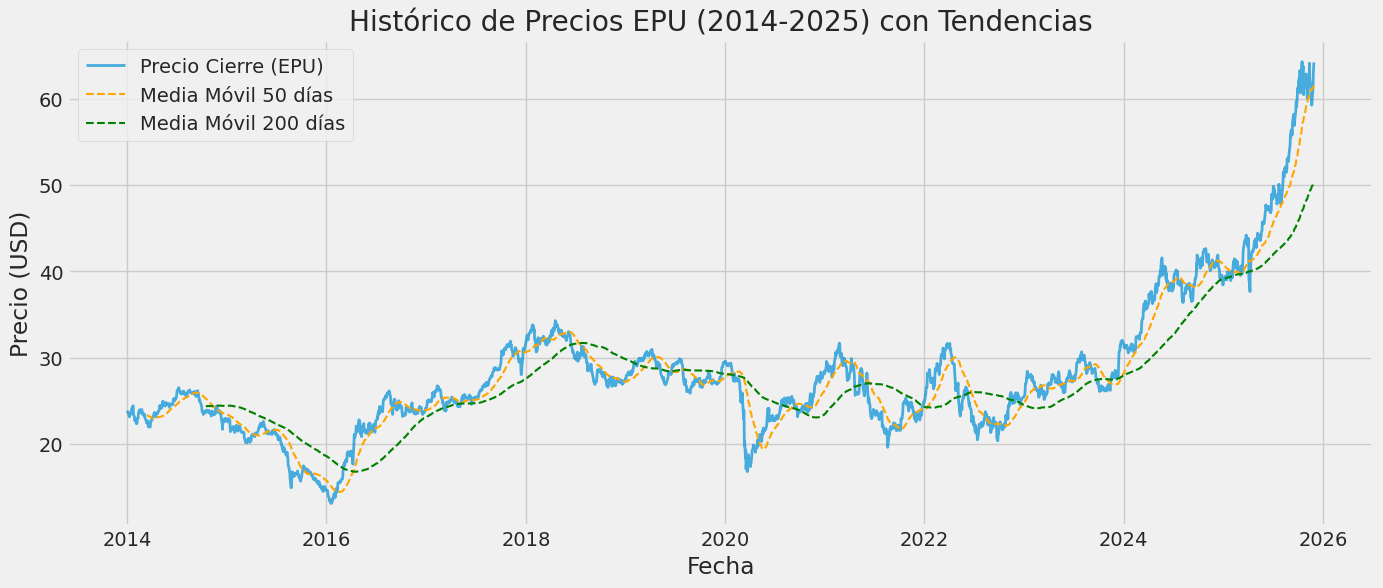

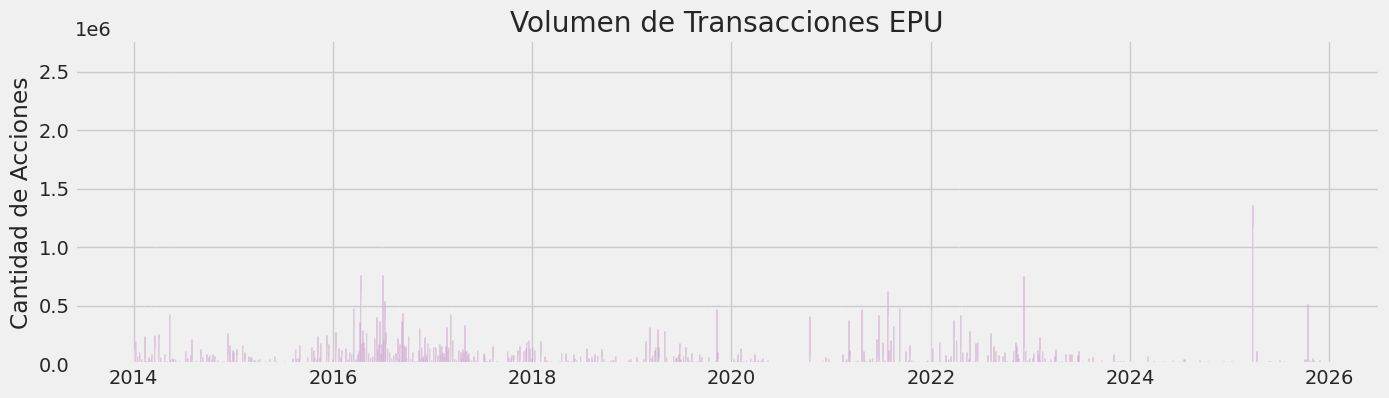

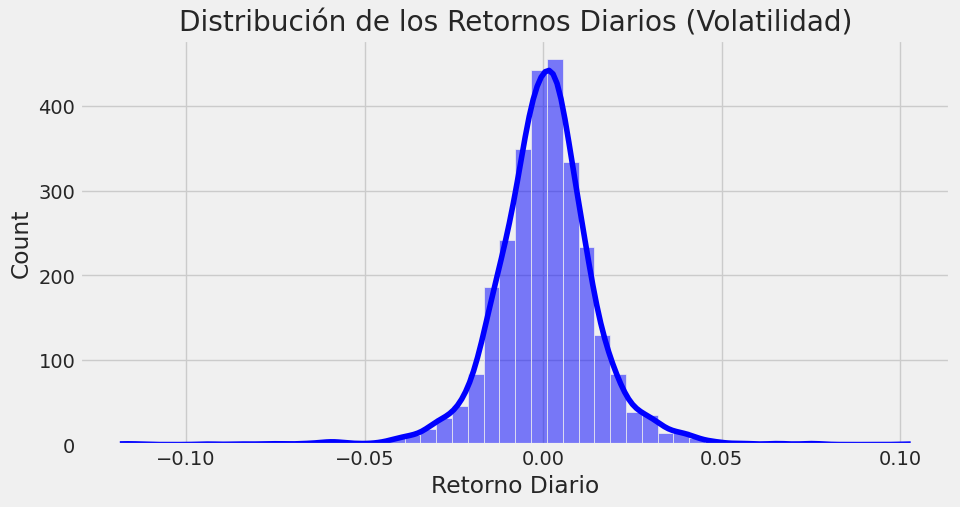

In [ ]:
# 5. GRÁFICOS

# FIGURA 1: Precio de Cierre y Medias Móviles
plt.figure(figsize=(15, 6))
plt.plot(data['Close'], label='Precio Cierre (EPU)', alpha=0.7, linewidth=2)
plt.plot(data['MA50'], label='Media Móvil 50 días', color='orange', linestyle='--', linewidth=1.5)
plt.plot(data['MA200'], label='Media Móvil 200 días', color='green', linestyle='--', linewidth=1.5)
plt.title(f'Histórico de Precios {ticker} (2014-2025) con Tendencias')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()

# FIGURA 2: Volumen de Transacciones
plt.figure(figsize=(15, 4))
plt.bar(data.index, data['Volume'], color='purple', alpha=0.5)
plt.title(f'Volumen de Transacciones {ticker}')
plt.ylabel('Cantidad de Acciones')
plt.show()

# FIGURA 3: Histograma de Retornos (Para ver si es normal/gaussiana)
plt.figure(figsize=(10, 5))
sns.histplot(data_eda['Daily Return'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribución de los Retornos Diarios (Volatilidad)')
plt.xlabel('Retorno Diario')
plt.show()

## Seccionamiento de data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. DEFINICIÓN DEL CORTE (SECCIONAMIENTO)
# Definimos la fecha de corte para validación
split_date = '2025-01-01'

# Dividimos los datos en dos dataframes
train_df = data.loc[data.index < split_date].copy()
test_df = data.loc[data.index >= split_date].copy()

print(f"Entrenamiento (2014-2023): {train_df.shape[0]} días")
print(f"Validación (2024-2025): {test_df.shape[0]} días")


Entrenamiento (2014-2023): 2768 días
Validación (2024-2025): 228 días


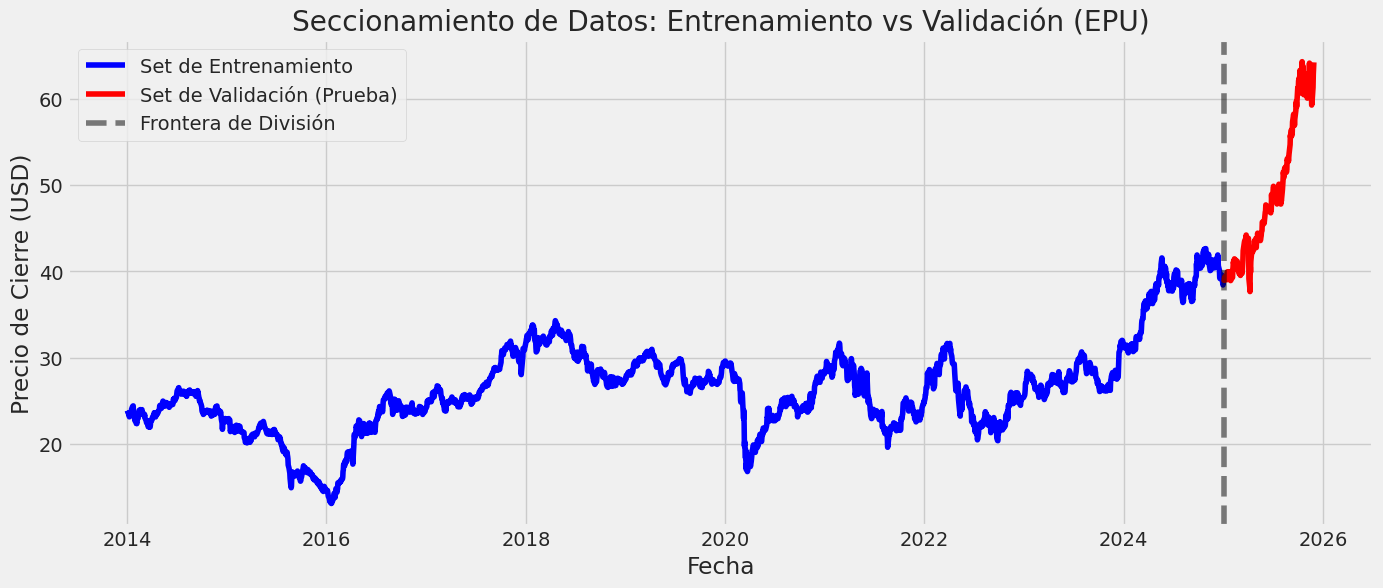

In [ ]:
# 2. VISUALIZACIÓN DEL SECCIONAMIENTO (El bloque movido)

plt.figure(figsize=(15, 6))
plt.plot(train_df['Close'], label='Set de Entrenamiento', color='blue')
plt.plot(test_df['Close'], label='Set de Validación (Prueba)', color='red')
plt.axvline(pd.Timestamp(split_date), color='black', linestyle='--', alpha=0.5, label='Frontera de División')
plt.title(f'Seccionamiento de Datos: Entrenamiento vs Validación ({ticker})')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.show()



## Normalizacion de la data

In [ ]:

# 3. ESCALAMIENTO (NORMALIZACIÓN)

scaler_inputs = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Ajustamos (Fit) SOLAMENTE con los datos de entrenamiento para evitar data leakage
scaler_inputs.fit(train_df[['Close', 'Volume']])
scaler_target.fit(train_df[['Close']])

# Transformamos ambos sets
train_scaled = scaler_inputs.transform(train_df[['Close', 'Volume']])
test_scaled = scaler_inputs.transform(test_df[['Close', 'Volume']])


## Creacion de secuencias

In [ ]:
# 4. GENERACIÓN DE SECUENCIAS (VENTANA DESLIZANTE)

def create_dataset(dataset, time_step=60):
    """
    Entrada: Array numpy escalado [[Close, Volume], ...]
    Salida:
        X -> Arrays de 'time_step' días con Close y Volume
        Y -> El precio de Close del día siguiente
    """
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        # Input: tomamos 'time_step' días (todas las columnas: Close y Volume)
        X.append(dataset[i:(i + time_step), :])

        # Output: la columna 0 es 'Close'. Queremos predecir el precio.
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Definimos la ventana de tiempo (Contexto que mira hacia atrás)
time_step = 60

# Creamos las secuencias
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Redimensionamos para LSTM [samples, time steps, features]
# Features = 2 (Close, Volume)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 2)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 2)

print("\nDimensiones finales para la LSTM:")
print(f"X_train: {X_train.shape}  (Muestras, Pasos, Variables)")
print(f"y_train: {y_train.shape}  (Muestras,)")


Dimensiones finales para la LSTM:
X_train: (2707, 60, 2)  (Muestras, Pasos, Variables)
y_train: (2707,)  (Muestras,)


## Arquitectura del modelo

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. DISEÑO DE LA ARQUITECTURA (MODELO)

model = Sequential()

# Primera capa LSTM
# input_shape=(time_step, 2) -> (60 días, Precio y Volumen)
# return_sequences=True es necesario para conectar con otra capa LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 2)))
model.add(Dropout(0.2)) # Previene overfitting apagando 20% de neuronas

# Segunda capa LSTM
# return_sequences=False porque la siguiente capa ya es densa (no secuencial)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Capas Densas (Red Neuronal clásica para interpretar)
model.add(Dense(25)) # Capa oculta
model.add(Dense(1))  # Capa de salida (1 sola neurona = Precio Predicho)

# Compilación del modelo
# 'adam' es el optimizador estándar, 'mean_squared_error' es ideal para regresión
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen de la arquitectura (pon esto en tu anexo de tesis)
model.summary()

# 2. CONFIGURACIÓN DE CALLBACKS (INTELIGENCIA DE ENTRENAMIENTO)

# EarlyStopping: Detiene el entrenamiento si 'val_loss' no mejora en 10 épocas
# restore_best_weights=True asegura que nos quedemos con el mejor modelo, no el último.
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,101 (125.39 KB)

 Trainable params: 32,101 (125.39 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [ ]:
# 3. ENTRENAMIENTO DEL MODELO

print("\nIniciando entrenamiento de la Red Neuronal...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), # Usamos los datos de 2024 para validar en tiempo real
    batch_size=32,       # Actualiza los pesos cada 32 datos
    epochs=100,          # Máximo de épocas (EarlyStopping lo detendrá antes probablemente)
    callbacks=[early_stop],
    verbose=1
)




Iniciando entrenamiento de la Red Neuronal...
Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0446 - val_loss: 0.0028
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch

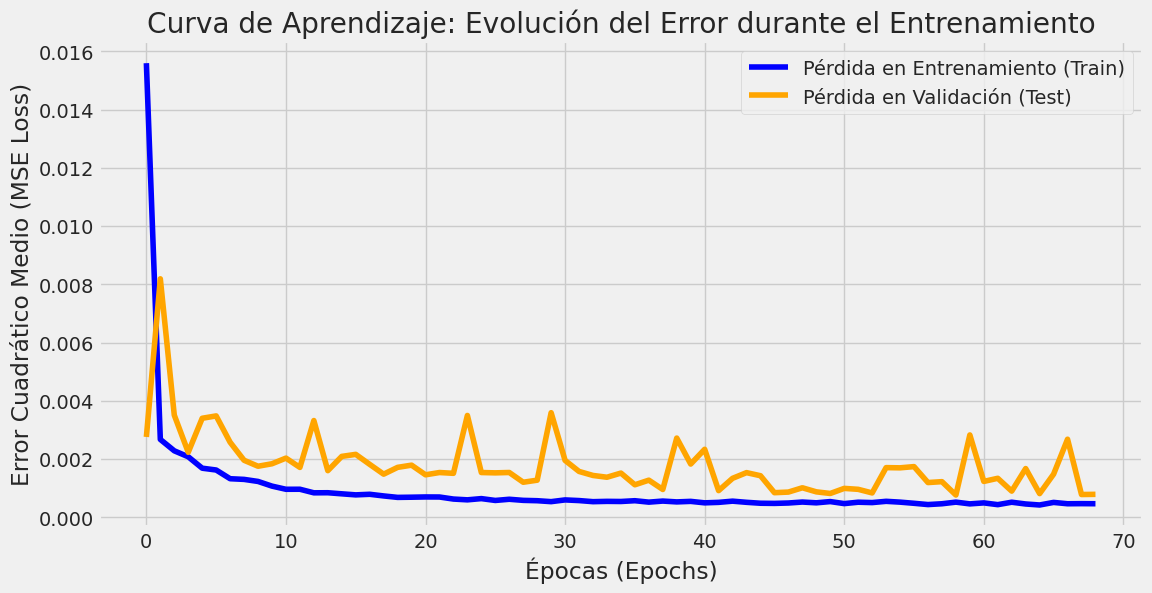

In [ ]:

# 4. DIAGNÓSTICO DEL APRENDIZAJE (CURVAS DE PÉRDIDA)

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento (Train)', color='blue')
plt.plot(history.history['val_loss'], label='Pérdida en Validación (Test)', color='orange')
plt.title('Curva de Aprendizaje: Evolución del Error durante el Entrenamiento')
plt.xlabel('Épocas (Epochs)')
plt.ylabel('Error Cuadrático Medio (MSE Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# 1. GENERACIÓN DE PREDICCIONES

# Hacemos que el modelo prediga sobre los datos de entrenamiento y validación
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 2. INVERSIÓN DEL ESCALADO (VOLVER A DÓLARES)
# El modelo predice valores entre 0 y 1. Debemos convertirlos a precio real.
# Usamos 'scaler_target' que creamos específicamente para la columna 'Close'.

train_predict_real = scaler_target.inverse_transform(train_predict)
y_train_real = scaler_target.inverse_transform([y_train])

test_predict_real = scaler_target.inverse_transform(test_predict)
y_test_real = scaler_target.inverse_transform([y_test])

# 3. CÁLCULO DE MÉTRICAS DE ERROR (PARA LA TESIS)

# RMSE (Root Mean Squared Error): Cuánto se desvía el modelo en promedio (penaliza errores grandes)
rmse_train = math.sqrt(mean_squared_error(y_train_real[0], train_predict_real[:,0]))
rmse_test = math.sqrt(mean_squared_error(y_test_real[0], test_predict_real[:,0]))

# MAE (Mean Absolute Error): Error promedio absoluto en dólares
mae_test = mean_absolute_error(y_test_real[0], test_predict_real[:,0])

# MAPE (Mean Absolute Percentage Error): Error en porcentaje (muy útil para explicar a gerencia)
mape_test = np.mean(np.abs((y_test_real[0] - test_predict_real[:,0]) / y_test_real[0])) * 100

print(f"\n--- RESULTADOS DE LA EVALUACIÓN ---")
print(f"RMSE (Error Cuadrático Medio) en Validación: {rmse_test:.4f}")
print(f"MAE (Error Absoluto Medio) en Validación: {mae_test:.4f} USD")
print(f"MAPE (Error Porcentual) en Validación: {mape_test:.2f}%")
print(f"Interpretación: El modelo se equivoca, en promedio, un {mape_test:.2f}% del precio real.")



85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

--- RESULTADOS DE LA EVALUACIÓN ---
RMSE (Error Cuadrático Medio) en Validación: 0.8210
MAE (Error Absoluto Medio) en Validación: 0.5968 USD
MAPE (Error Porcentual) en Validación: 1.15%
Interpretación: El modelo se equivoca, en promedio, un 1.15% del precio real.


Fechas test: 167 vs Predicciones test: 167


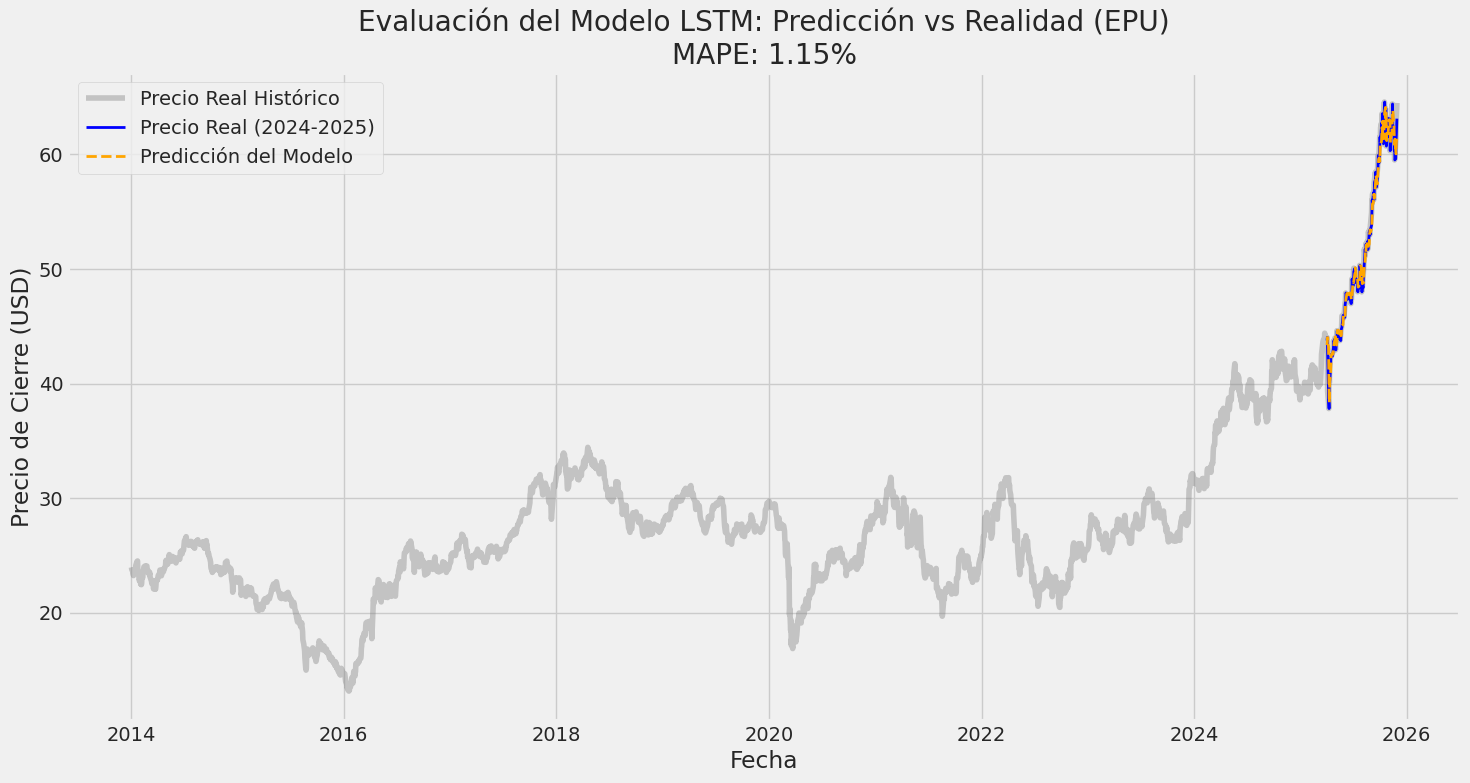

In [ ]:
# 4. GRÁFICA FINAL DE COMPARACIÓN (CORREGIDO V2)

# SOLUCIÓN: Usamos .flatten() antes de medir la longitud (len)
# Esto asegura que contemos los 419 datos, y no el "paquete" de 1.

# Alineamos fechas de entrenamiento
train_dates = train_df.index[-len(y_train_real.flatten()):]

# Alineamos fechas de validación
test_dates = test_df.index[-len(y_test_real.flatten()):]

# Verificación rápida (opcional, para que veas que ahora sí coinciden)
print(f"Fechas test: {len(test_dates)} vs Predicciones test: {len(y_test_real.flatten())}")

plt.figure(figsize=(16, 8))

# 1. Graficamos la historia completa (Gris)
plt.plot(data.index, data['Close'], label='Precio Real Histórico', color='gray', alpha=0.4)

# 2. Graficamos la validación (Azul vs Naranja)
plt.plot(test_dates, y_test_real.flatten(), label='Precio Real (2024-2025)', color='blue', linewidth=2)
plt.plot(test_dates, test_predict_real.flatten(), label='Predicción del Modelo', color='orange', linestyle='--', linewidth=2)

plt.title(f'Evaluación del Modelo LSTM: Predicción vs Realidad ({ticker})\nMAPE: {mape_test:.2f}%')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.show()

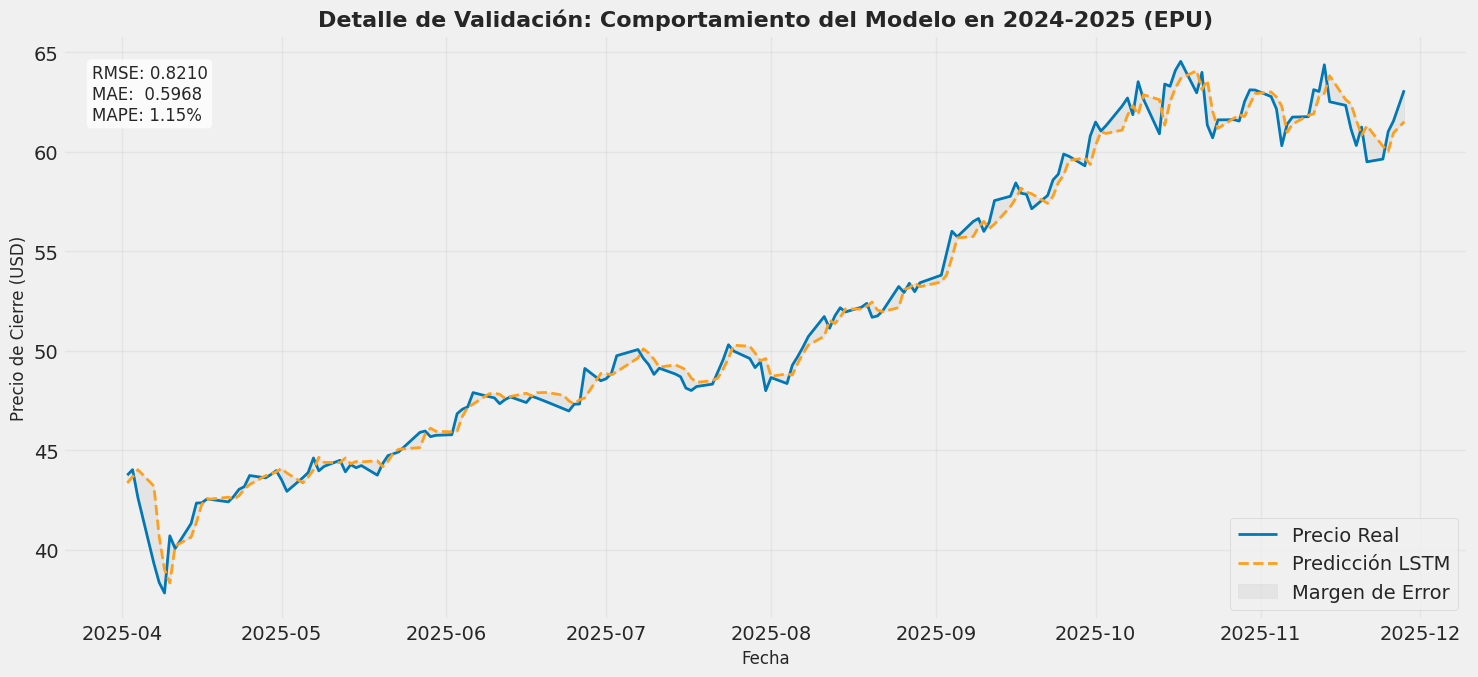

In [ ]:
# ==========================================
# 5. GRÁFICA DE DETALLE (ZOOM EN VALIDACIÓN)
# ==========================================

plt.figure(figsize=(15, 7))

# 1. Graficamos los datos Reales vs Predichos
plt.plot(test_dates, y_test_real.flatten(), label='Precio Real', color='#0077b6', linewidth=2)
plt.plot(test_dates, test_predict_real.flatten(), label='Predicción LSTM', color='#ff9f1c', linestyle='--', linewidth=2)

# 2. Rellenar el área de error (Opcional pero muy visual para tesis)
# Pinta de rojo suave el espacio entre la realidad y la predicción para resaltar el error
plt.fill_between(test_dates, y_test_real.flatten(), test_predict_real.flatten(), color='gray', alpha=0.1, label='Margen de Error')

# 3. Títulos y Etiquetas
plt.title(f'Detalle de Validación: Comportamiento del Modelo en 2024-2025 ({ticker})', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)

# 4. Añadir una caja de texto con las métricas dentro del gráfico
textstr = '\n'.join((
    f'RMSE: {rmse_test:.4f}',
    f'MAE:  {mae_test:.4f}',
    f'MAPE: {mape_test:.2f}%'
))

# Propiedades de la caja de texto
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# Colocamos la caja en la esquina superior izquierda (coordenadas relativas 0.02, 0.95)
plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:

# ==========================================
# 5. PREDICCIÓN DEL FUTURO (SIGUIENTE DÍA HÁBIL)
# ==========================================
# Tomamos los últimos 60 días (time_step) de toda la data disponible (Close y Volume)
# Recordar: test_scaled contiene la data más reciente normalizada

last_60_days = test_scaled[-time_step:] # Forma: (60, 2)
input_future = last_60_days.reshape(1, time_step, 2) # Forma: (1, 60, 2)

# Predicción
future_pred_scaled = model.predict(input_future)
future_price = scaler_target.inverse_transform(future_pred_scaled)

last_real_date = data.index[-1].strftime('%Y-%m-%d')
last_real_price = data['Close'].iloc[-1]

print(f"\n--- PREDICCIÓN FUTURA ---")
print(f"Última fecha con datos reales: {last_real_date} (Cierre: ${last_real_price:.2f})")
print(f"El modelo predice que para el SIGUIENTE día hábil, el precio será: ${future_price[0][0]:.2f}")

# Pequeña lógica de tendencia
diff = future_price[0][0] - last_real_price
trend = "SUBIDA" if diff > 0 else "BAJADA"
print(f"Tendencia esperada: {trend} (${abs(diff):.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

--- PREDICCIÓN FUTURA ---
Última fecha con datos reales: 2025-11-28 (Cierre: $64.47)
El modelo predice que para el SIGUIENTE día hábil, el precio será: $63.84
Tendencia esperada: BAJADA ($0.63)


## Tunning parameters

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# ==========================================
# 0. CONFIGURACIÓN DE REPRODUCIBILIDAD
# ==========================================
# Esto asegura que los experimentos sean "científicos" y repetibles
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# ==========================================
# 1. DEFINICIÓN DE LA GRILLA (GRID SEARCH)
# ==========================================
# Parámetros a probar. Si tarda mucho, elimina opciones de las listas.
param_grid = {
    'units': [50, 100],            # ¿Cerebro mediano o grande?
    'dropout_rate': [0.1, 0.2],    # ¿Cuánto olvidar para no memorizar?
    'layers': [1, 2],              # ¿Arquitectura simple o profunda?
    'learning_rate': [0.001, 0.0005] # ¿Aprender rápido o con cuidado?
}

# Generamos todas las combinaciones posibles
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"--- INICIANDO TUNING ---")
print(f"Total de modelos a entrenar: {len(combinations)}")
print(f"Datos de entrada: {X_train.shape}")

# ==========================================
# 2. BUCLE DE ENTRENAMIENTO
# ==========================================

best_mape = float('inf')
best_params = {}
best_model_name = 'best_lstm_tuned.keras'

# Arrays para guardar el historial de todos los intentos (para tu anexo de tesis)
history_results = []

for i, params in enumerate(combinations):
    print(f"\n[{i+1}/{len(combinations)}] Probando: {params} ...")

    # Limpiamos memoria de sesiones anteriores
    clear_session()
    set_seeds() # Reseteamos semillas para que la inicialización de pesos sea justa

    # --- CONSTRUCCIÓN DEL MODELO ---
    model = Sequential()

    # Capa 1 (Siempre va)
    # Si hay una segunda capa, return_sequences debe ser True. Si no, False.
    return_seq_layer1 = True if params['layers'] == 2 else False

    model.add(LSTM(units=params['units'],
                   return_sequences=return_seq_layer1,
                   input_shape=(time_step, 2)))
    model.add(Dropout(params['dropout_rate']))

    # Capa 2 (Condicional)
    if params['layers'] == 2:
        model.add(LSTM(units=params['units'], return_sequences=False))
        model.add(Dropout(params['dropout_rate']))

    # Capa de Salida
    model.add(Dense(1))

    # --- COMPILACIÓN ---
    opt = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')

    # --- ENTRENAMIENTO ---
    # Usamos EarlyStopping para no perder tiempo si el modelo es malo
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=40,          # Suficiente para ver convergencia
        batch_size=32,
        callbacks=[es],
        verbose=0           # Silencioso (cambia a 1 si quieres ver la barra de cada uno)
    )

    # --- EVALUACIÓN ---
    # Predecimos sobre test (2024-2025)
    preds_scaled = model.predict(X_test, verbose=0)

    # Invertimos escalado
    preds_real = scaler_target.inverse_transform(preds_scaled)
    # Aseguramos que y_test tenga la forma correcta para comparar
    y_test_real_check = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Calculamos MAPE
    current_mape = np.mean(np.abs((y_test_real_check - preds_real) / y_test_real_check)) * 100

    print(f"   > Resultado MAPE: {current_mape:.4f}%")

    # Guardamos resultado en lista
    res_dict = params.copy()
    res_dict['MAPE'] = current_mape
    history_results.append(res_dict)

    # --- CHECK DE MEJORA ---
    if current_mape < best_mape:
        print(f"   >>> ¡NUEVO RÉCORD! (Mejora de {best_mape:.4f}% a {current_mape:.4f}%)")
        best_mape = current_mape
        best_params = params
        model.save(best_model_name)

# ==========================================
# 3. RESULTADOS FINALES
# ==========================================

print("\n" + "="*50)
print("FIN DEL AJUSTE DE HIPERPARÁMETROS")
print("="*50)
print(f"MEJOR MAPE CONSEGUIDO: {best_mape:.4f}%")
print(f"MEJORES PARÁMETROS: {best_params}")

# Convertimos los resultados a DataFrame para que los puedas poner en tu tesis
df_results = pd.DataFrame(history_results)
df_results = df_results.sort_values(by='MAPE', ascending=True)

print("\nTop 5 Mejores Configuraciones:")
print(df_results.head(5))

# ==========================================
# 4. CARGAR EL MEJOR MODELO PARA USARLO
# ==========================================
from tensorflow.keras.models import load_model

print(f"\nCargando el mejor modelo desde '{best_model_name}'...")
final_model = load_model(best_model_name)
print("Modelo listo para graficar.")

--- INICIANDO TUNING ---
Total de modelos a entrenar: 16
Datos de entrada: (2707, 60, 2)

[1/16] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.7574%
   >>> ¡NUEVO RÉCORD! (Mejora de inf% a 1.7574%)

[2/16] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 2.2231%

[3/16] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.9816%

[4/16] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 3.4204%

[5/16] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.5082%
   >>> ¡NUEVO RÉCORD! (Mejora de 1.7574% a 1.5082%)

[6/16] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 2.0909%

[7/16] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 2.6678%

[8/16] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 2.9234%

[9/16] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.2830%
   >>> ¡NUEVO RÉCORD! (Mejora de 1.5082% a 1.2830%)

[10/16] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 2.2431%

[11/16] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.8112%

[12/16] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.9631%

[13/16] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.5924%

[14/16] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.8728%

[15/16] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 2.3007%

[16/16] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > Resultado MAPE: 1.8998%

FIN DEL AJUSTE DE HIPERPARÁMETROS
MEJOR MAPE CONSEGUIDO: 1.2830%
MEJORES PARÁMETROS: {'units': 100, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001}

Top 5 Mejores Configuraciones:
    units  dropout_rate  layers  learning_rate      MAPE
8     100           0.1       1          0.001  1.282993
4      50           0.2       1          0.001  1.508225
12    100           0.2       1          0.001  1.592424
0      50           0.1       1          0.001  1.757361
10    100           0.1       2          0.001  1.811168

Cargando el mejor modelo desde 'best_lstm_tuned.keras'...
Modelo listo para graficar.


# LSTM Univariado (Close)

Entrenamiento: 2768 días
Validación: 228 días

Entrenando Modelo Univariado...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0341 - val_loss: 0.0052
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0028 - val_loss: 0.0170
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0026 - val_loss: 0.0142
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0019 - val_loss: 0.0119
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 8.5

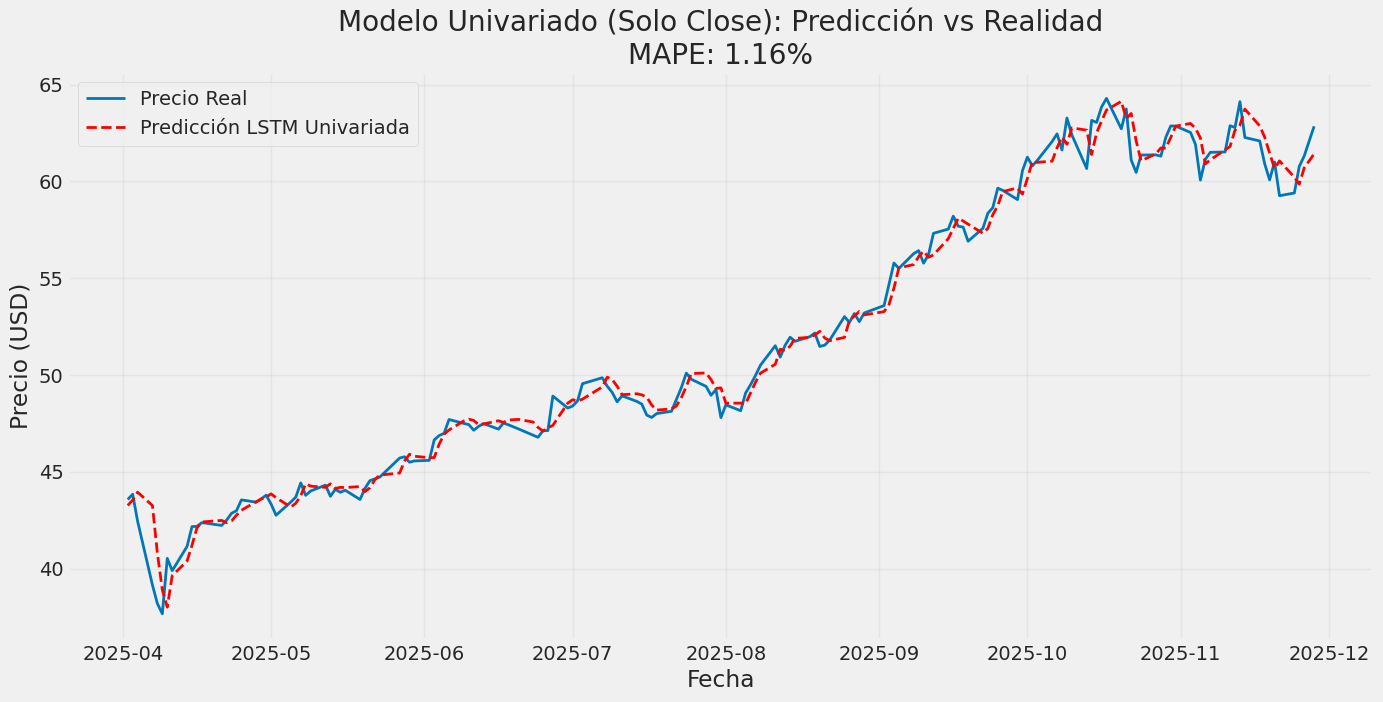

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ==========================================
# 1. PREPARACIÓN DE DATOS (UNIVARIADO)
# ==========================================

# Asumimos que 'data' ya está descargada con yfinance (EPU)
# Seleccionamos SOLO la columna 'Close'
df_uni = data[['Close']].copy()

# División Train/Test (Respetando fechas)
split_date = '2025-01-01'
train_df = df_uni.loc[df_uni.index < split_date].copy()
test_df = df_uni.loc[df_uni.index >= split_date].copy()

print(f"Entrenamiento: {train_df.shape[0]} días")
print(f"Validación: {test_df.shape[0]} días")

# ==========================================
# 2. ESCALAMIENTO (Simplificado)
# ==========================================
# Al ser univariado, solo necesitamos UN escalador para todo.
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit solo en train
scaler.fit(train_df)

# Transformamos
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

# ==========================================
# 3. GENERACIÓN DE SECUENCIAS
# ==========================================
def create_dataset_uni(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        # Input: 60 días previos
        X.append(dataset[i:(i + time_step), 0])
        # Output: El día siguiente
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60

X_train, y_train = create_dataset_uni(train_scaled, time_step)
X_test, y_test = create_dataset_uni(test_scaled, time_step)

# Reshape para LSTM [samples, time steps, features]
# Features es 1 porque solo usamos Precio
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# ==========================================
# 4. MODELO LSTM (Simplificado)
# ==========================================
model = Sequential()

# input_shape=(time_step, 1) -> El 1 es clave aquí
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nEntrenando Modelo Univariado...")
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    callbacks=[early_stop],
    verbose=1
)

# ==========================================
# 5. PREDICCIÓN Y EVALUACIÓN
# ==========================================
preds = model.predict(X_test)

# Inversión de escala (Solo usamos el 'scaler' único)
preds_real = scaler.inverse_transform(preds)
y_test_real = scaler.inverse_transform([y_test]) # Ojo con el reshape implícito aquí

# Alineación de fechas para gráficas y métricas
# Usamos .flatten() para evitar errores de dimensiones
test_dates = test_df.index[-len(y_test_real.flatten()):]

# Métricas
rmse = math.sqrt(mean_squared_error(y_test_real.flatten(), preds_real.flatten()))
mape = np.mean(np.abs((y_test_real.flatten() - preds_real.flatten()) / y_test_real.flatten())) * 100

print(f"\n--- RESULTADOS UNIVARIADOS ---")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.4f}")

# ==========================================
# 6. GRÁFICA FINAL
# ==========================================
plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_test_real.flatten(), label='Precio Real', color='#0077b6', linewidth=2)
plt.plot(test_dates, preds_real.flatten(), label=f'Predicción LSTM Univariada', color='red', linestyle='--', linewidth=2)
plt.title(f'Modelo Univariado (Solo Close): Predicción vs Realidad\nMAPE: {mape:.2f}%')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ==========================================
# 7. GENERACIÓN DE TABLA COMPARATIVA
# ==========================================

# 1. Aplanamos los arrays para asegurarnos que sean de 1 dimensión
real_data = y_test_real.flatten()
pred_data = preds_real.flatten()
diff_data = real_data - pred_data

# 2. Creamos el DataFrame
df_comparativo = pd.DataFrame({
    'Fecha': test_dates,
    'Valor Real': real_data,
    'Predicción': pred_data,
    'Diferencia (Real - Pred)': diff_data
})

# 3. Opcional: Agregar el error porcentual absoluto por día
# Esto ayuda a ver en qué días el modelo falló más
df_comparativo['Error Abs (%)'] = (abs(df_comparativo['Diferencia (Real - Pred)']) / df_comparativo['Valor Real']) * 100

# 4. Redondear decimales para que se vea limpio en el artículo
# Redondeamos precios a 4 decimales y porcentaje a 2
df_comparativo = df_comparativo.round({'Valor Real': 4, 'Predicción': 4, 'Diferencia (Real - Pred)': 4, 'Error Abs (%)': 2})

# 5. IMPRIMIR LA TABLA
print("\n=== TABLA DETALLADA: REAL vs PRONÓSTICO ===")
pd.set_option('display.max_rows', 20) # Muestra primeras y últimas filas si son muchas
print(df_comparativo)

# 6. (Opcional) Guardar en Excel o CSV para copiar a tu documento/Word/LaTeX
# df_comparativo.to_csv('tabla_resultados_lstm.csv', index=False)
# print("\nTabla guardada como 'tabla_resultados_lstm.csv'")


=== TABLA DETALLADA: REAL vs PRONÓSTICO ===
         Fecha  Valor Real  Predicción  Diferencia (Real - Pred)  \
0   2025-04-02     43.5636   43.257500                    0.3062   
1   2025-04-03     43.8373   43.537899                    0.2994   
2   2025-04-04     42.4396   43.941898                   -1.5023   
3   2025-04-07     39.1457   43.252102                   -4.1064   
4   2025-04-08     38.1878   40.780602                   -2.5928   
..         ...         ...         ...                       ...   
162 2025-11-21     59.2560   61.054401                   -1.7984   
163 2025-11-24     59.3954   60.213600                   -0.8182   
164 2025-11-25     60.7698   59.852501                    0.9172   
165 2025-11-26     61.3075   60.693199                    0.6143   
166 2025-11-28     62.8412   61.415901                    1.4253   

     Error Abs (%)  
0             0.70  
1             0.68  
2             3.54  
3            10.49  
4             6.79  
..          

### Tunning

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import MinMaxScaler

# ==========================================
# 0. CONFIGURACIÓN INICIAL Y SEMILLAS
# ==========================================
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# ==========================================
# 1. PREPARACIÓN DE DATOS (UNIVARIADO 2025)
# ==========================================
# Asumimos que 'data' ya existe. Usamos solo 'Close'.
df_uni = data[['Close']].copy()

# FECHA DE CORTE SOLICITADA: 2025-01-01
split_date = '2025-01-01'

train_df = df_uni.loc[df_uni.index < split_date].copy()
test_df = df_uni.loc[df_uni.index >= split_date].copy()

print(f"--- DATOS UNIVARIADOS ---")
print(f"Entrenamiento (Hasta 2024): {len(train_df)} días")
print(f"Prueba (Desde 2025): {len(test_df)} días")

# Escalamiento
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df)
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

# Función de secuencias (Time Step)
def create_dataset_uni(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset_uni(train_scaled, time_step)
X_test, y_test = create_dataset_uni(test_scaled, time_step)

# Reshape para LSTM [samples, time steps, features=1]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# ==========================================
# 2. DEFINICIÓN DE LA GRILLA (GRID SEARCH)
# ==========================================
# Parámetros a probar para romper la barrera del 1.14%
param_grid = {
    'units': [50, 100, 128],       # Probamos una red más grande (128)
    'dropout_rate': [0.1, 0.2],    # 0.1 suele ser mejor si tienes mucha data
    'layers': [1, 2],              # 1 capa suele ganar en univariado
    'learning_rate': [0.001, 0.0005]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"\n--- INICIANDO TUNING ---")
print(f"Total de combinaciones a probar: {len(combinations)}")

# ==========================================
# 3. BUCLE DE ENTRENAMIENTO
# ==========================================

best_mape = float('inf')
best_params = {}
best_model_name = 'best_lstm_uni_2025.keras'
history_results = []

for i, params in enumerate(combinations):
    print(f"\n[{i+1}/{len(combinations)}] Probando: {params} ...")

    clear_session()
    set_seeds()

    # Construcción del modelo Univariado
    model = Sequential()

    # Capa 1
    return_seq = True if params['layers'] == 2 else False
    # input_shape es (time_step, 1) -> 1 sola feature (Precio)
    model.add(LSTM(units=params['units'],
                   return_sequences=return_seq,
                   input_shape=(time_step, 1)))
    model.add(Dropout(params['dropout_rate']))

    # Capa 2 (Opcional)
    if params['layers'] == 2:
        model.add(LSTM(units=params['units'], return_sequences=False))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(1))

    # Compilación
    opt = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=opt, loss='mean_squared_error')

    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0)

    # Entrenamiento
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=40,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # Evaluación
    preds_scaled = model.predict(X_test, verbose=0)

    # Inversión
    preds_real = scaler.inverse_transform(preds_scaled)
    y_test_real_check = scaler.inverse_transform(y_test.reshape(-1, 1))

    # MAPE
    current_mape = np.mean(np.abs((y_test_real_check - preds_real) / y_test_real_check)) * 100

    print(f"   > MAPE: {current_mape:.4f}%")

    # Guardar resultados
    res = params.copy()
    res['MAPE'] = current_mape
    history_results.append(res)

    if current_mape < best_mape:
        print(f"   >>> ¡MEJORA DETECTADA! ({best_mape:.4f}% -> {current_mape:.4f}%)")
        best_mape = current_mape
        best_params = params
        model.save(best_model_name)

# ==========================================
# 4. RESULTADOS FINALES
# ==========================================
print("\n" + "="*40)
print(f"MEJOR MAPE CONSEGUIDO: {best_mape:.4f}%")
print(f"MEJORES PARÁMETROS: {best_params}")
print("="*40)

# Mostrar Top 3
df_res = pd.DataFrame(history_results).sort_values(by='MAPE')
print(df_res.head(3))

--- DATOS UNIVARIADOS ---
Entrenamiento (Hasta 2024): 2768 días
Prueba (Desde 2025): 228 días

--- INICIANDO TUNING ---
Total de combinaciones a probar: 24

[1/24] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.7410%
   >>> ¡MEJORA DETECTADA! (inf% -> 1.7410%)

[2/24] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 2.1901%

[3/24] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.9424%

[4/24] Probando: {'units': 50, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.7152%
   >>> ¡MEJORA DETECTADA! (1.7410% -> 1.7152%)

[5/24] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.5699%
   >>> ¡MEJORA DETECTADA! (1.7152% -> 1.5699%)

[6/24] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 2.0808%

[7/24] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.5670%
   >>> ¡MEJORA DETECTADA! (1.5699% -> 1.5670%)

[8/24] Probando: {'units': 50, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 2.6909%

[9/24] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.2669%
   >>> ¡MEJORA DETECTADA! (1.5670% -> 1.2669%)

[10/24] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.8862%

[11/24] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.8381%

[12/24] Probando: {'units': 100, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.7756%

[13/24] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.7625%

[14/24] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.6537%

[15/24] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.3285%

[16/24] Probando: {'units': 100, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.9566%

[17/24] Probando: {'units': 128, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.2171%
   >>> ¡MEJORA DETECTADA! (1.2669% -> 1.2171%)

[18/24] Probando: {'units': 128, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.3616%

[19/24] Probando: {'units': 128, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 2.0508%

[20/24] Probando: {'units': 128, 'dropout_rate': 0.1, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 2.0903%

[21/24] Probando: {'units': 128, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.3230%

[22/24] Probando: {'units': 128, 'dropout_rate': 0.2, 'layers': 1, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.4808%

[23/24] Probando: {'units': 128, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.001} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 2.0345%

[24/24] Probando: {'units': 128, 'dropout_rate': 0.2, 'layers': 2, 'learning_rate': 0.0005} ...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


   > MAPE: 1.7327%

MEJOR MAPE CONSEGUIDO: 1.2171%
MEJORES PARÁMETROS: {'units': 128, 'dropout_rate': 0.1, 'layers': 1, 'learning_rate': 0.001}
    units  dropout_rate  layers  learning_rate      MAPE
16    128           0.1       1          0.001  1.217089
8     100           0.1       1          0.001  1.266893
20    128           0.2       1          0.001  1.323035


## Validacion

### arima

Iniciando predicción ARIMA para 228 días...
Esto puede tardar un poco porque el modelo se ajusta paso a paso.
Día 50/228 procesado.
Día 100/228 procesado.
Día 150/228 procesado.
Día 200/228 procesado.

--- RESULTADOS ARIMA (Comparativa) ---
RMSE ARIMA: 0.7564
MAE ARIMA:  0.5538
MAPE ARIMA: 1.11%


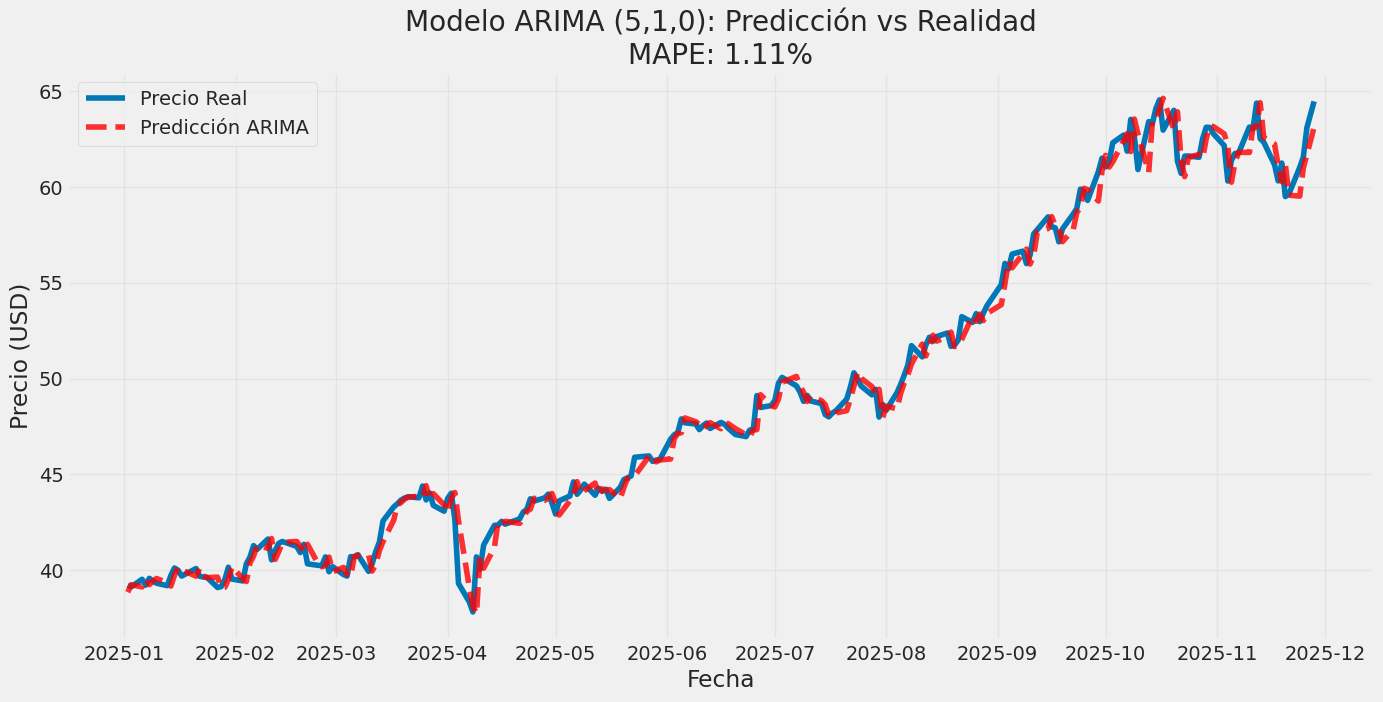

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ==========================================
# 1. PREPARACIÓN DE DATOS (UNIVARIADO)
# ==========================================
# Usamos los mismos DataFrames que ya tienes: train_df y test_df
# ARIMA trabaja mejor con los precios reales (sin escalar), así que usamos la columna directa.

train_data_arima = train_df['Close'].values
test_data_arima = test_df['Close'].values

# Historial inicial: Todo el set de entrenamiento
history = [x for x in train_data_arima]
predictions_arima = []

# ==========================================
# 2. BUCLE DE PREDICCIÓN (ROLLING FORECAST)
# ==========================================
print(f"Iniciando predicción ARIMA para {len(test_data_arima)} días...")
print("Esto puede tardar un poco porque el modelo se ajusta paso a paso.")

# Hiperparámetros de ARIMA (p,d,q)
# (5,1,0) es una configuración estándar para acciones diarias:
# p=5: Mira los últimos 5 días (una semana de bolsa).
# d=1: Aplica una diferenciación (resta el día actual menos el anterior) para estabilizar la tendencia.
# q=0: Sin medias móviles complejas.
arima_order = (5, 1, 0)

for t in range(len(test_data_arima)):
    # 1. Crear el modelo con la historia disponible hasta hoy
    model = ARIMA(history, order=arima_order)

    # 2. Entrenar (Ajustar)
    model_fit = model.fit()

    # 3. Predecir el siguiente paso (t+1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)

    # 4. Agregar la observación real a la historia para la siguiente vuelta
    obs = test_data_arima[t]
    history.append(obs)

    # Opcional: Imprimir progreso cada 50 días para no desesperarse
    if (t+1) % 50 == 0:
        print(f"Día {t+1}/{len(test_data_arima)} procesado.")

# ==========================================
# 3. EVALUACIÓN (MÉTRICAS)
# ==========================================

rmse_arima = math.sqrt(mean_squared_error(test_data_arima, predictions_arima))
mae_arima = mean_absolute_error(test_data_arima, predictions_arima)
mape_arima = np.mean(np.abs((test_data_arima - predictions_arima) / test_data_arima)) * 100

print(f"\n--- RESULTADOS ARIMA (Comparativa) ---")
print(f"RMSE ARIMA: {rmse_arima:.4f}")
print(f"MAE ARIMA:  {mae_arima:.4f}")
print(f"MAPE ARIMA: {mape_arima:.2f}%")

# ==========================================
# 4. GRÁFICA COMPARATIVA: REAL vs ARIMA
# ==========================================

plt.figure(figsize=(15, 7))
plt.plot(test_df.index, test_data_arima, label='Precio Real', color='#0077b6')
plt.plot(test_df.index, predictions_arima, label='Predicción ARIMA', color='red', linestyle='--', alpha=0.8)
plt.title(f'Modelo ARIMA (5,1,0): Predicción vs Realidad\nMAPE: {mape_arima:.2f}%')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### XGBoost

In [ ]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,EPU,EPU,EPU,EPU,EPU
Date,,,,,
2014-01-02,23.964020,24.169629,23.637883,23.680424,138100
2014-01-03,23.808050,24.034928,23.786778,23.928578,121100
2014-01-06,23.616617,23.772594,23.538627,23.609526,62000
2014-01-07,23.722965,23.886034,23.574077,23.808047,173600
2014-01-08,23.389736,23.850581,23.333015,23.559893,201800


--- RESULTADOS XGBOOST (CON RETORNOS) ---
MAPE Mejorado: 1.11%


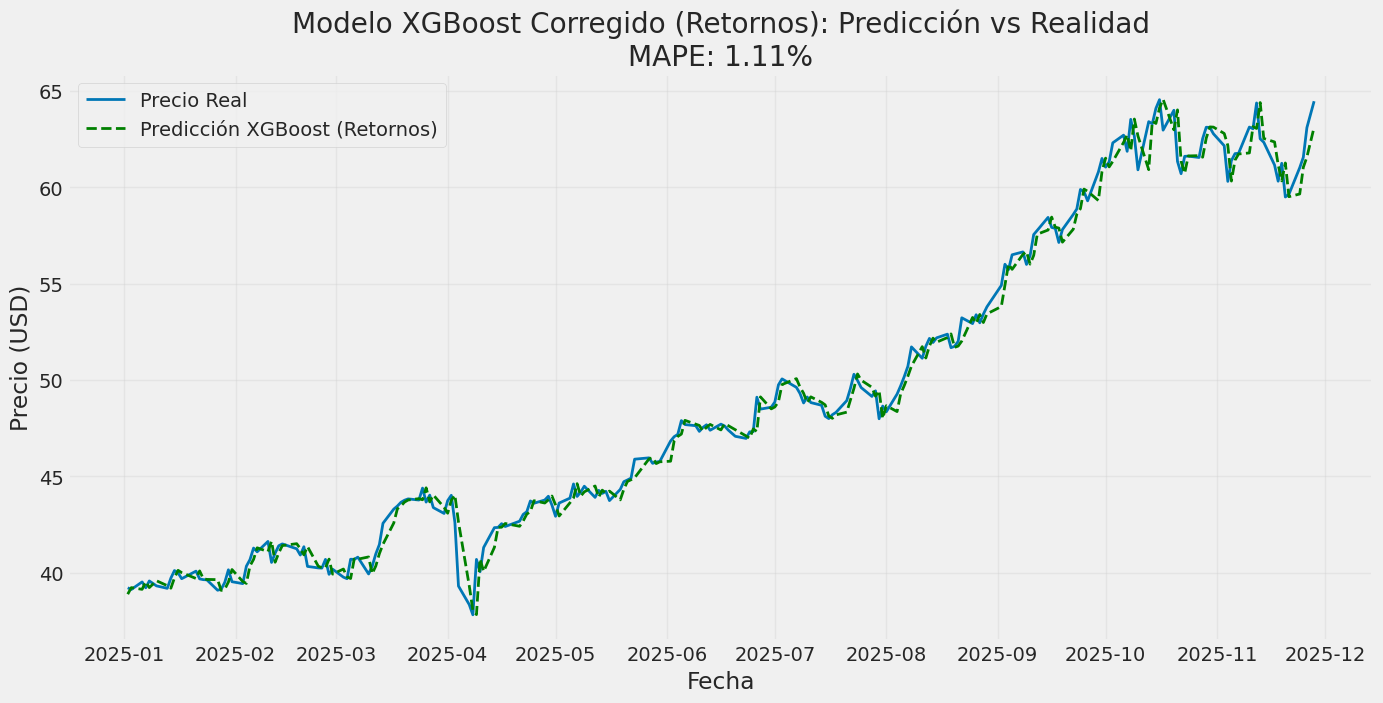

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ==========================================
# 1. TRANSFORMACIÓN A RETORNOS (LA SOLUCIÓN)
# ==========================================

df_xgb = data[['Close', 'Volume']].copy()

# En lugar de precio bruto, calculamos el cambio porcentual (Retorno)
# Esto hace que los datos sean "Estacionarios" (Stationary)
df_xgb['Return'] = df_xgb['Close'].pct_change()
df_xgb['Vol_Change'] = df_xgb['Volume'].pct_change()

df_xgb.dropna(inplace=True) # Eliminamos el primer NaN generado

window_size = 60

# Generamos lags PERO de los Retornos, no de los precios
cols_to_concat = [df_xgb]
for i in range(1, window_size + 1):
    shifted = df_xgb[['Return', 'Vol_Change']].shift(i)
    shifted.columns = [f'Ret_lag_{i}', f'Vol_lag_{i}']
    cols_to_concat.append(shifted)

df_transformed = pd.concat(cols_to_concat, axis=1)
df_transformed.dropna(inplace=True)

# Definimos X e y
# Ahora 'y' es el RETORNO del día, no el precio
y = df_transformed['Return']
X = df_transformed.drop(['Close', 'Volume', 'Return', 'Vol_Change'], axis=1)

# ==========================================
# 2. DIVISIÓN TRAIN / TEST
# ==========================================
split_date = '2025-01-01'
mask_train = X.index < split_date
mask_test = X.index >= split_date

X_train, y_train = X.loc[mask_train], y.loc[mask_train]
X_test, y_test = X.loc[mask_test], y.loc[mask_test]

# ==========================================
# 3. ENTRENAMIENTO XGBOOST
# ==========================================
model_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# ==========================================
# 4. PREDICCIÓN Y RECONSTRUCCIÓN DE PRECIO
# ==========================================
# El modelo nos da predicciones de % de cambio (ej. 0.01, -0.005)
pred_returns = model_xgb.predict(X_test)

# Necesitamos reconstruir el precio: Precio_Hoy = Precio_Ayer * (1 + Retorno_Predicho)
# Obtenemos los precios reales "de ayer" para hacer el cálculo One-Step-Ahead
prev_prices = data.loc[X_test.index, 'Close'].shift(1)
# El primer valor será NaN porque shift mueve todo, lo llenamos con el precio real anterior al corte
# (Es un detalle técnico menor, pero necesario para graficar)
prev_prices.iloc[0] = data.loc[data.index < split_date, 'Close'].iloc[-1]

# Reconstruimos:
predicted_prices = prev_prices * (1 + pred_returns)
real_prices = data.loc[X_test.index, 'Close']

# ==========================================
# 5. EVALUACIÓN Y GRÁFICO
# ==========================================
# Convertimos a numpy para métricas limpias
y_real = real_prices.values
y_pred = predicted_prices.values

rmse_xgb = math.sqrt(mean_squared_error(y_real, y_pred))
mape_xgb = np.mean(np.abs((y_real - y_pred) / y_real)) * 100

print(f"--- RESULTADOS XGBOOST (CON RETORNOS) ---")
print(f"MAPE Mejorado: {mape_xgb:.2f}%")

plt.figure(figsize=(15, 7))
plt.plot(real_prices.index, y_real, label='Precio Real', color='#0077b6', linewidth=2)
plt.plot(real_prices.index, y_pred, label='Predicción XGBoost (Retornos)', color='green', linestyle='--', linewidth=2)
plt.title(f'Modelo XGBoost Corregido (Retornos): Predicción vs Realidad\nMAPE: {mape_xgb:.2f}%')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Gráfico generado exitosamente: pipeline_metodologia.png


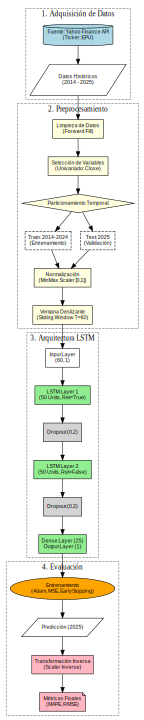

In [ ]:
import graphviz

# Configuración del gráfico
dot = graphviz.Digraph('pipeline_metodologia', comment='Metodología LSTM EPU')
dot.attr(rankdir='TB', size='10', newrank='true')  # Top to Bottom
dot.attr('node', shape='box', style='filled', fillcolor='white', fontname='Helvetica', fontsize='10')
dot.attr('edge', fontname='Helvetica', fontsize='9')

# --- 1. ADQUISICIÓN DE DATOS ---
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='1. Adquisición de Datos', style='dashed', color='grey40')
    c.node('A', 'Fuente: Yahoo Finance API\n(Ticker: EPU)', shape='cylinder', fillcolor='lightblue')
    c.node('B', 'Datos Históricos\n(2014 - 2025)', shape='parallelogram')
    c.edge('A', 'B')

# --- 2. PREPROCESAMIENTO ---
with dot.subgraph(name='cluster_1') as c:
    c.attr(label='2. Preprocesamiento', style='dashed', color='grey40')
    c.node('C', 'Limpieza de Datos\n(Forward Fill)', fillcolor='lightyellow')
    c.node('D', 'Selección de Variables\n(Univariado: Close)', fillcolor='lightyellow')
    c.node('E', 'Particionamiento Temporal', shape='diamond', fillcolor='lightyellow')
    c.node('F', 'Train: 2014-2024\n(Entrenamiento)', style='dashed')
    c.node('G', 'Test: 2025\n(Validación)', style='dashed')

    c.node('H', 'Normalización\n(MinMax Scaler [0,1])', fillcolor='lightyellow')
    c.node('I', 'Ventana Deslizante\n(Sliding Window T=60)', fillcolor='lightyellow')

    c.edge('B', 'C')
    c.edge('C', 'D')
    c.edge('D', 'E')
    c.edge('E', 'F')
    c.edge('E', 'G')
    c.edge('F', 'H')
    c.edge('G', 'H')
    c.edge('H', 'I')

# --- 3. MODELADO LSTM ---
with dot.subgraph(name='cluster_2') as c:
    c.attr(label='3. Arquitectura LSTM', style='dashed', color='grey40')
    c.node('J', 'Input Layer\n(60, 1)', shape='box')
    c.node('K', 'LSTM Layer 1\n(50 Units, Ret=True)', fillcolor='lightgreen')
    c.node('L', 'Dropout (0.2)', fillcolor='lightgrey')
    c.node('M', 'LSTM Layer 2\n(50 Units, Ret=False)', fillcolor='lightgreen')
    c.node('N', 'Dropout (0.2)', fillcolor='lightgrey')
    c.node('O', 'Dense Layer (25)\nOutput Layer (1)', fillcolor='lightgreen')

    c.edge('I', 'J')
    c.edge('J', 'K')
    c.edge('K', 'L')
    c.edge('L', 'M')
    c.edge('M', 'N')
    c.edge('N', 'O')

# --- 4. ENTRENAMIENTO Y EVALUACIÓN ---
with dot.subgraph(name='cluster_3') as c:
    c.attr(label='4. Evaluación', style='dashed', color='grey40')
    c.node('P', 'Entrenamiento\n(Adam, MSE, EarlyStopping)', shape='ellipse', fillcolor='orange')
    c.node('Q', 'Predicción (2025)', shape='parallelogram')
    c.node('R', 'Transformación Inversa\n(Scaler Inverse)', fillcolor='lightpink')
    c.node('S', 'Métricas Finales\n(MAPE, RMSE)', shape='note', fillcolor='lightpink')

    c.edge('O', 'P')
    c.edge('P', 'Q')
    c.edge('Q', 'R')
    c.edge('R', 'S')

# Renderizar y guardar
output_path = dot.render('pipeline_metodologia', format='png', cleanup=True)
print(f"Gráfico generado exitosamente: {output_path}")

# Mostrar en el notebook (opcional)
dot